In [2]:
# %load utilities
#!/usr/bin/env python

# In[3]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewtest

def romanToInt(i):   
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    j = 0
    num = 0
    while j < len(i):
        if j+1<len(i) and i[j:j+2] in roman:
            num+=roman[i[j:j+2]]
            j+=2
        else:

            num+=roman[i[j]]
            j+=1
    return num

def skew_df(df):
    skewness, p_value = skewtest(df)
    dskew=pd.DataFrame(np.round(np.vstack((skewness.T,p_value.T)),2),columns=df.columns,
                    index=['skewness', 'p_value'])
    return(dskew)
		
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],'r')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC - TPR vs FPR')

In [3]:
#Import Dataset
df = pd.read_csv('loan_default_prediction.csv')
print(df.shape)

(87500, 30)


In [4]:
#drop
vdrop=['ID','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL','File_Status','Claim_Type','Due_Fee']
df=df.drop(vdrop,axis=1)
df.shape

(87500, 17)

In [5]:
#Conversão dos anos de experiência para numérico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
#Conversão da duração para numérico
df['Duration']=df['Duration'].apply(lambda i : i.replace(' years','years')).astype(str)
#Conversão da GGGrade valor ordinal para numérico
df['GGGrade']=df['GGGrade'].apply(romanToInt).astype(int)
#criacao de debt to income
#calcular o total da divida e o rendimento anual. uma espécie de "taxa de esforço"
df['debt_to_income']=df['Unpaid_Amount']/df['Yearly_Income']
#ver resultado
#df.head()

In [6]:
#eliminar observações com pelo menos uma feature sem valores
df=df.dropna()
#drop duplicates
df.drop_duplicates()
df.shape

(77376, 18)

In [7]:
#df.describe()
df.head(5)

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Default,debt_to_income
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3years,31216.05,debt consolidation,0,0.049268
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5years,11660.49,debt consolidation,0,0.136407
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5years,5637.87,major purchase,0,0.071185
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3years,15607.17,major purchase,1,0.253363
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5years,27472.86,debt consolidation,0,0.403693


In [8]:
v_num_cont=['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate',
            'Present_Balance','Unpaid_Amount','debt_to_income']
v_num_disc=['Unpaid_2_years','Already_Defaulted','Account_Open']
v_cat_ord=['Home_Status','State','Reason','Duration']#,'GGGrade']

In [9]:
#fazer histograma das categoricas e value_counts (verificar se há categorias de pouca relevancia)
for i in v_cat_ord:
    print(df[i].value_counts())

MORTGAGE    39077
RENT        30853
OWN          7436
OTHER           6
NONE            4
Name: Home_Status, dtype: int64
California    11194
Newyork        6414
TX             6307
Florida        5149
IL             3091
NewJersey      2877
PA             2797
Ohio           2602
GA             2572
VA             2251
NC             2230
MI             1995
Maryland       1857
AZ             1797
MA             1764
CO             1685
WA             1627
MN             1493
IN             1276
MO             1253
TN             1184
CT             1172
NV             1039
AL              999
WI              990
OR              929
LA              908
SC              888
KY              728
KS              722
OK              676
AR              564
UT              556
NM              424
HI              423
MS              370
NH              365
WV              344
RI              337
MT              225
DC              206
DE              205
AK              198
WY              16

In [10]:
from scipy import stats
display(df.shape)
#remover observações com home status 'none' e 'other'
df=df[(df['Home_Status']!='OTHER')&(df['Home_Status']!='NONE')]
#remover linhas com outliers, definidos como mais que 3 desvios-padrão acima/abaixo da média
df=df[(np.abs(stats.zscore(df[v_num_cont])) < 3).all(axis=1)]
df.shape


(77376, 18)

(74542, 18)

# Undersampling

In [11]:
#ver quantas observações têm default=1
display((df['Default']==1).sum())
#sample de 5000 obs com default =1
defaulted = df[df['Default']==1].sample(n=5000, random_state=101)
#sample de 5000 obs com default =0
notdefault = df[df['Default']==0].sample(n=5000, random_state=101)
#agregar as observações
df = pd.concat([defaulted,notdefault],axis=0)
#sort aleatório das obs
df = df.sample(frac=1).reset_index(drop=True)
df.shape

14184

(10000, 18)

In [12]:
df[v_num_disc].describe()

,Unpaid_2_years,Already_Defaulted,Account_Open
count,10000.000000,10000.000000,10000.000000
mean,0.315900,0.005300,12.526900
std,0.855792,0.076632,5.129104
min,0.000000,0.000000,2.000000
25%,0.000000,0.000000,9.000000
50%,0.000000,0.000000,12.000000
75%,0.000000,0.000000,15.000000
max,16.000000,2.000000,51.000000


In [13]:
#fazer histograma das categoricas e value_counts (verificar se há categorias de pouca relevancia)
for i in v_cat_ord:
    print(df[i].value_counts())

MORTGAGE    4985
RENT        4096
OWN          919
Name: Home_Status, dtype: int64
California    1526
TX             811
Newyork        775
Florida        651
IL             391
NewJersey      366
PA             365
GA             344
Ohio           344
NC             312
MI             274
VA             265
Maryland       250
AZ             245
CO             226
WA             226
MA             216
MN             199
TN             151
MO             149
NV             143
IN             142
OR             139
SC             133
AL             128
WI             120
CT             119
LA             114
KS              88
AR              88
OK              81
KY              79
UT              73
HI              60
NM              52
RI              52
WV              43
DC              40
NH              37
MS              31
MT              28
AK              28
DE              24
WY              19
SD              18
NE              14
VT              11
ME               5
ND   

# Train vs test sample: standard and cross-validation

In [14]:
# Split the data into features (X) and labels (y)
#QUANDO PIPELINE ESTIVER PARA TODAS AS VARIÁVEIS, MUDAR O X
X = df[v_num_cont]
X = df[v_num_cont+v_num_disc+v_cat_ord]
y = df['Default']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#script não ativado para fazer cross validation manual (normalmente o scikit learn faz tudo automático)
from sklearn.model_selection import KFold
#kfold = KFold(n_splits=5,shuffle=True)
#for train_index, test_index in kfold.split(X):
#    print("Train index:", train_index, "Test index:", test_index)
#    X_train, X_test = X.loc[train_index], X.loc[test_index]
#    y_train, y_test = y.loc[train_index], y.loc[test_index]

# Pipelines

In [15]:
#1a parte: tentar reduzir assimetria das variáveis

#criar função que devolve uma métrica de assimetria das variáveis e avalia se essa variável
#está suficientemente distante de 0 para ter certeza que é assimétrica
#como se vê isso? quanto mais pequeno for o p-value (2a linha dataframe), mais certezas temos que é assimétrica

#verificar assimetria das features numéricas
dskew=skew_df(X_train[v_num_cont+v_num_disc])
#mostrar output
display(dskew)
#ver lista de features assimétricas, pvalue < 5%
v_skew=list(dskew.columns[dskew.loc['p_value']<0.05])
#lista de simétricas são as restantes
v_sym=list(set(X_train[v_num_cont+v_num_disc].columns) - set(v_skew))
#check
v_skew

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,Account_Open
skewness,13.62,-5.61,38.07,23.07,-0.17,-6.08,34.57,42.44,33.81,75.28,108.83,34.24
p_value,0.00,0.00,0.00,0.00,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00


['Asst_Reg',
 'Experience',
 'Yearly_Income',
 'Lend_Amount',
 'Usage_Rate',
 'Present_Balance',
 'Unpaid_Amount',
 'debt_to_income',
 'Unpaid_2_years',
 'Already_Defaulted',
 'Account_Open']

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Define the transformations to apply to the column
transformer = ColumnTransformer([
    ('yeoj', PowerTransformer(), v_skew), #aplico transformação que corrige assimetria às assimétricas
    ('std', StandardScaler(), v_sym),     #aplico transformação às simétricas (sub média e dividir desvio padrao)7
    ('oneh', OneHotEncoder(min_frequency=0.05,handle_unknown='ignore',#drop='if_biNameErrorary',
                           sparse_output=False), v_cat_ord)
])

#pipeline= Pipeline([
    #('ct', transformer),
    #('to_df', pd.DataFrame, {'columns': v_skew+v_sym})
    #("pandarizer",FunctionTransformer(lambda x: pd.DataFrame(x, columns = (v_skew + v_sym))))
#])

# Transform the data
pfit = transformer.fit(X_train)

categories= pfit.transformers_[2][1].categories_
categories_out=pfit.transformers_[2][1].infrequent_categories_

v_onehot_drop=list(np.concatenate([np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))],axis=0))


v_onehot=list(np.concatenate([(np.concatenate((np.array(j),
                       (np.array(['Other_Cat'+str(k)]) if categories_out[k] is not None else np.array([]))),axis=0)) 
                         for k,j in enumerate(
                         [np.concatenate([categories[i][np.isin(categories[i], categories_out[i], invert=True)]],axis=0) 
                        for i in range(0,len(categories))]
                         )]))

X_train_transf = transformer.transform(X_train)
X_train_transf = pd.DataFrame(transformer.transform(X_train),columns = (v_skew + v_sym+v_onehot)
                              ,index=X_train.index)

#aplicar transformações ao teste calcula
X_test_transf = transformer.transform(X_test)
X_test_transf = pd.DataFrame(transformer.transform(X_test),columns = (v_skew + v_sym+v_onehot)
                            ,index=X_test.index)

display(round(X_train_transf.describe(),2))
#vamos dar um check se o dataframe ficou "menos assimétrico"
skew_df(X_train_transf[v_skew+v_sym])


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,...,Florida,Newyork,TX,Other_Cat1,credit card,debt consolidation,home improvement,Other_Cat2,3years,5years
count,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,...,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00,8000.00
mean,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,...,0.07,0.08,0.08,0.62,0.24,0.60,0.05,0.11,0.73,0.27
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.25,0.27,0.28,0.48,0.43,0.49,0.23,0.31,0.45,0.45
min,-2.27,-1.52,-3.94,-2.62,-2.37,-3.94,-3.44,-2.09,-0.48,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.86,-0.83,-0.68,-0.73,-0.72,-0.80,-0.67,-0.77,-0.48,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.00,0.05,0.02,-0.03,0.05,-0.06,-0.03,-0.01,-0.48,-0.07,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00
75%,0.92,1.09,0.67,0.76,0.76,0.85,0.66,0.74,-0.48,-0.07,...,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00
max,1.48,1.09,2.89,1.97,2.37,2.09,3.26,2.43,2.11,13.93,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,debt_to_income,Unpaid_2_years,Already_Defaulted,Account_Open,Interest_Charged
skewness,-5.87,-8.93,-0.0,-1.68,-7.03,-2.23,1.02,2.94,42.31,105.32,0.0,-0.17
p_value,0.00,0.00,1.0,0.09,0.00,0.03,0.31,0.00,0.00,0.00,1.0,0.86


In [17]:
#fazer histograma das categoricas e value_counts (verificar se há categorias de pouca relevancia)
cc=[]
for i in v_cat_ord:
    c=df[i].value_counts()/df.shape[0]
    list(c[c>.05].index)
    print(list(c[c>.05].index))
    #cc=cc+c
    
cc

['MORTGAGE', 'RENT', 'OWN']
['California', 'TX', 'Newyork', 'Florida']
['debt  consolidation', 'credit  card', 'home  improvement']
['3years', '5years']


[]

# Feature selection/Unsupervise Learning

## PCA

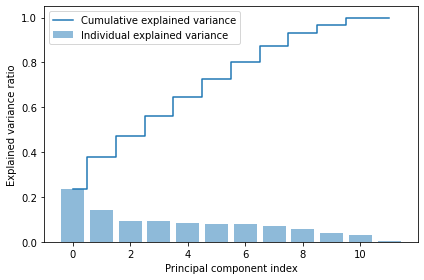

In [26]:
#Apply PCA to the training data to reduce the dimensionality
#ALWAYS STANDARDIZE
#VER SE VALE A PENA FAZER UNS GRAFICOS
#POR EXEMPLO
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=0.9999)

X_pca=pca.fit(X_train_transf[v_skew+v_sym])
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [27]:
pca = PCA(n_components=0.80)

X_pca=pca.fit(X_train_transf[v_skew+v_sym])

X_train_pca=pd.DataFrame(pca.transform(X_train_transf[v_skew+v_sym]),
                         columns=['pca_v'+str(i+1) for i in range (0,X_pca.n_components_)],
                        index=X_train_transf.index)

X_test_pca=pd.DataFrame(pca.transform(X_test_transf[v_skew+v_sym]),
                         columns=['pca_v'+str(i+1) for i in range (0,X_pca.n_components_)],
                        index=X_test_transf.index)

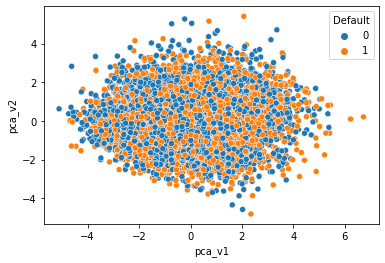

In [28]:
import seaborn as sns

df_pca=pd.concat([X_train_pca,pd.DataFrame(y_train)],axis=1)
#display(df_pca.head(5))

sns.scatterplot(x='pca_v1', y='pca_v2', hue='Default', data=df_pca);



,pca_v1,pca_v2,pca_v3,pca_v4,pca_v5,pca_v6,pca_v7,Default
Default,0.06,-0.04,0.01,-0.29,-0.16,0.38,-0.13,1.0


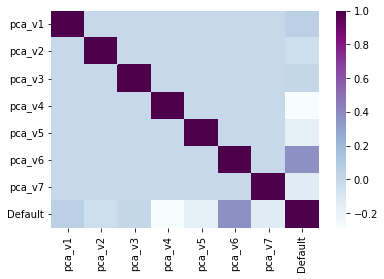

In [30]:
corr = df_pca.corr()
display(round(corr.iloc[[-1],:],2))

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap="BuPu");

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Use cross-validation to evaluate logistic regression with different numbers of principal components
pca = PCA()
logreg = LogisticRegression()

n_components = range(1, X_train_transf[v_skew+v_sym].shape[1]+1)
scores = []

for n in n_components:
    pca.n_components = n
    X_train_pca = pca.fit_transform(X_train_transf[v_skew+v_sym])
    score = np.mean(cross_val_score(logreg, X_train_pca, y_train, cv=5, scoring='f1'))
    scores.append(score)

# Select the number of components that gives the highest cross-validation score
optimal_n_components = n_components[np.argmax(scores)]
display(scores)

# Train logistic regression model on full training set with optimal number of components
pca.n_components = optimal_n_components
display(optimal_n_components)

[0.4866731606461615,
 0.4989364577457548,
 0.499425220037243,
 0.6286368741322044,
 0.6525908657573309,
 0.7227140567160227,
 0.7298497979893682,
 0.7304849401249144,
 0.7283284607845604,
 0.7293881386262491,
 0.7289386498792372,
 0.7282133619775626]

8

## Kmeans, LogisticRegression

In [24]:
sse=[]
silhscores = []
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
k_rng=range(2,15)
for k in k_rng:
    km=KMeans(n_clusters=k,n_init=10)
    km.fit(X_train_transf)
    km_pred=km.predict(X_train_transf)
    silhscore = silhouette_score(X_train_transf, km_pred)
    sse.append(km.inertia_)
    silhscores.append(silhscore)
display(silhscores)    
sse

[0.12970152647273597,
 0.1347077437387277,
 0.10451162559524897,
 0.08847057776113482,
 0.09197347285739622,
 0.08532217418756645,
 0.07825047051476035,
 0.08364784517804215,
 0.07940255348616079,
 0.07791955865692873,
 0.07464007292106573,
 0.07665052731525387,
 0.07557958373594892]

[97427.7039436652,
 89302.85450791016,
 83294.7282750825,
 79442.13012095698,
 75406.59487734073,
 73260.25403870821,
 71370.50962643638,
 69920.83139241992,
 68154.3459825124,
 66988.86033666001,
 65888.96828750121,
 64967.76448747646,
 63955.48606604157]

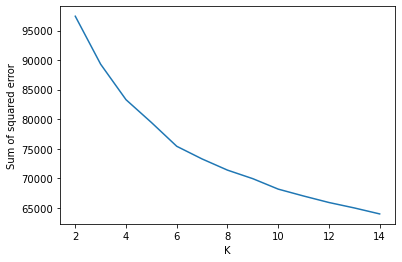

In [25]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse);

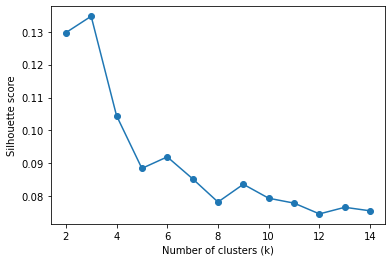

In [28]:
# Plot the silhouette scores
plt.plot(range(2, 15), silhscores, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Create a pipeline with KMeans and OneHotEncoder
pipeline = Pipeline([
    ('kmeans', KMeans(n_init=10)),  # leave the number of clusters unspecified
    ('onehot', OneHotEncoder()),
    ('lr', LogisticRegression())
])

# Create a grid search with cross-validation to find the best number of clusters
param_grid = {'kmeans__n_clusters': range(2, 15)}  # specify the range of cluster numbers to try
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_transf, y_train)

# Print the best number of clusters and the best f1 score
print(f"Best number of clusters: {grid_search.best_params_['kmeans__n_clusters']}")
print(f"Best f1 score: {grid_search.best_score_:.2f}")

In [ ]:
display(grid_clf.best_params_)

grid_clf.score(X_test, y_test)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, KFold

# Apply K-means clustering to the training data
kmeans = KMeans(n_clusters=5)
X_train_clusters = kmeans.fit_predict(X_train_transf)
X_test_clusters = kmeans.predict(X_test_transf)

# Create the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train_clusters.reshape(-1, 1), y_train)

########################################
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set up the cross-validation and grid search
kfold = KFold(n_splits=5)
param_grid = {'n_clusters': [2, 3, 4, 5, 6]}
model = KMeans()
grid_search = GridSearchCV(model, param_grid, cv=kfold, return_train_score=True)

# Run the grid search
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Re-train the model on the entire dataset with the best parameters
model = KMeans(**grid_search.best_params_)
X_clusters = model.fit_predict(X)

# Models

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LogisticRegression()
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

## SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LinearSVC(loss='hinge',max_iter=10000)
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')

# Fit the model to the data
grid_search.fit(X_train_transf, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test_transf)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree_clf=DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train_transf,y_train)
y_pred=tree_clf.predict(X_test)

In [ ]:
from sklearn.tree import plot_tree
plot_tree(tree_clf);

## Naive Bayes

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
est=KBinsDiscretizer(n_bins=5,encode='ordinal',strategy='uniform')
est.fit(X_train)
Xt_train=est.transform(X_train_transf)
Xt_test=est.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnNB=MultinomialNB()
mnNB.fit(Xt_train,y_train)
y_pred=mnNB.predict(Xt_test)

from sklearn.naive_bayes import GaussianNB
gNB=MultinomialNB()
gNB.fit(X_train_transf,y_train)
y_pred=gNB.predict(X_test)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_Model=RandomForestClassifier()
rf_Model.fit(X_train_transf,y_train)
y_pred=rf_Model.predict(X_test_transf)

In [ ]:
#number of trees
n_estimators=[int(x) for x in np.linspace(10,100,4)]
#number of splits to consider at every split
max_features=['auto','sqrt']
#maximum number of levels
max_depth=[2,4]
#min of samples required to split a node
min_samples_split=[2,5]
#min samples required at each leaf node
min_samples_leaf=[1,2]
#method of selecting samples for training each tree
bootstrap=[True,False]

param_grid={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,
            'bootstrap':bootstrap
}

In [ ]:
from sklearn.model_selection import GridSearchCV
rf_Grid=GridSearchCV(rf_Model,param_grid,cv=5)
rf_Grid.fit(X_train_transf,y_train)

In [ ]:

y_pred=rf_Grid.predict(X_test)
rf_Grid.best_score_

## Kneighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)
y_pred=knn_clf.predict(X_test)

## Xgboost

In [ ]:
import xgboost as xgb
# Define the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',  # binary classification
    'max_depth': 5,  # maximum depth of the tree
    'learning_rate': 0.1,  # learning rate
    'n_estimators': 100  # number of trees to be built
}

# Create the XGBoost model
model = xgb.XGBClassifier(**params)

# Train the model
model.fit(X_train_transf, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_transf)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
##########################
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier

# Load the data
X = np.array(X)
y = np.array(y)

# Set up the cross-validation and grid search
kfold = KFold(n_splits=5)
param_grid = {'learning_rate': [0.1, 0.2, 0.3],
              'max_depth': [3, 4, 5],
              'n_estimators': [100, 200, 300]}
model = XGBClassifier()
grid_search = GridSearchCV(model, param_grid, cv=kfold, return_train_score=True)

# Run the grid search
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Re-train the model on the entire dataset with the best parameters
model = XGBClassifier(**grid_search.best_params_)
model.fit(X, y)

## Redes neuronais

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)

# Train the model on the training data
model.fit(X_train, y_train)

# Test the model on the test data
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)
##################################################### Set up the cross-validation and grid search
kfold = KFold(n_splits=5)
param_grid = {'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
              'solver': ['adam', 'sgd'],
              'activation': ['relu', 'tanh']}
model = MLPClassifier(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=kfold, return_train_score=True)

# Run the grid search
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Re-train the model on the entire dataset with the best parameters
model = MLPClassifier(max_iter=1000, **grid_search.best_params_)
model.fit(X, y)


###########################################################
import numpy as np
import tensorflow as tf

# Load the data
X, y = load_data()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert the labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),  # hidden layer
    tf.keras.layers.Dense(y_train_one_hot.shape[1], activation='softmax')  # output layer
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32)

# Predict the labels for the test set
y_pred_one_hot = model.predict(X_test)

# Convert the one-hot encoding back to labels
y_pred = np.argmax(y_pred_one_hot, axis=1)

# Evaluate the model using accuracy
accuracy = sum(y_pred == y_test) / len(y_test)
print(f'Accuracy: {accuracy:.2f}')

# Combinação de modelos

In [ ]:
#VOTING

#sklearn.ensemble.VotingClassifie

In [ ]:
# Fit different models and evaluate their performance
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

for model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__}: {accuracy:.2f}")
    
    #STACKING
# Define the base models
base_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

# Define the second-level model
meta_model = LogisticRegression()

# Define the stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_model.predict(X_test)

# Evaluate the model
accuracy = stacking_model.score(X_test, y_test)
print("Accuracy:", accuracy)


# Avaliação de performance

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
#print(accuracy_score(y_test,y_pred))
#print(precision_score(y_test,y_pred))
#print(recall_score(y_test,y_pred))
#print(f1_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='g');

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues');

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    
plot_roc_curve(fpr,tpr)

# Spike

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Use Recursive Feature Elimination (RFE) to select the top 2 features
rfe = RFE(model, 2)
rfe.fit(X_train, y_train)

# Transform the training and test data using the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test data
predictions = model.predict(X_test_selected)

# Print the accuracy
print(accuracy_score(y_test, predictions))

############################################################
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Create a list of all the feature indices
feature_indices = list(range(X.shape[1]))

# Set the initial set of features to be an empty list
selected_features = []

# Set the maximum number of features to select
max_features = 2

# Initialize the best cross-validated score to be negative infinity
best_score = -np.inf

# Iterate over all possible combinations of features
for i in range(1, len(feature_indices) + 1):
    for combination in combinations(feature_indices, i):
        # Select the current combination of features
        X_selected = X[:, combination]
        
        # Train a logistic regression model with 5-fold cross-validation
        model = LogisticRegression()
        score = cross_val_score(model, X_selected, y, cv=5).mean()
        
        # If the current combination of features has a higher cross-validated score than the best score, update the best score and the selected features
        if score > best_score:
            best_score = score
            selected_features = combination

# Print the selected features
print(selected_features)
##########################################
#BACKWARD

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Create a list of all the feature indices
feature_indices = list(range(X.shape[1]))

# Set the initial set of features to be all the features
selected_features = feature_indices

# Set the minimum number of features to select
min_features = 1

# Initialize the best cross-validated score to be negative infinity
best_score = -np.inf

# Iterate over all possible combinations of features
while len(selected_features) > min_features:
    scores = []
    for i in range(len(selected_features)):
        # Select the current combination of features
        X_selected = X[:, selected_features]
        
        # Train a logistic regression model with 5-fold cross-validation
        model = LogisticRegression()
        score = cross_val_score(model, X_selected, y, cv=5).mean()
        
        # Add the score for the current combination of features
        scores.append(score)
    
    # Find the index of the feature with the lowest score
    worst_feature_index = np.argmin(scores)
    
    # If the current combination of features has a higher cross-validated score than the best score, update the best score and the selected features
    if scores[worst_feature_index] > best_score:
        best_score = scores[worst_feature_index]
        selected_features = selected_features[:worst_feature_index] + selected_features[worst_feature_index + 1:]
    else:
        # If the current combination of features has a lower cross-validated score than the best score, stop the search
        break

# Print the selected features
print(selected_features)

In [ ]:
#CLUSTERING AS PREPROCESSING DATA INTO CLASSIFICATION PROBLEM
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use KMeans to cluster the training data into 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

# Add the cluster labels as a new feature in the training data
X_train_clustered = np.concatenate((X_train, kmeans.labels_.reshape(-1, 1)), axis=1)

# Create a Random Forest classifier and train it on the clustered data
model = RandomForestClassifier()
model.fit(X_train_clustered, y_train)

# Add the cluster labels as a new feature in the test data
X_test_clustered = np.concatenate((X_test, kmeans.predict(X_test).reshape(-1, 1)), axis=1)

# Make predictions on the test data
predictions = model.predict(X_test_clustered)

One way to pick the optimal number of clusters for a clustering algorithm is to use an evaluation metric that compares the quality of different clusterings. There are many such metrics available, such as the silhouette score, the Calinski-Harabasz index, and the Davies-Bouldin index.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# Try clustering the data with different numbers of clusters
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)

    # Calculate the silhouette score for this number of clusters
    score = silhouette_score(X, cluster_labels)
    print("Number of clusters:", n_clusters, "Silhouette score:", score)
    
    ###################
#PROF DOC

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
("kmeans", KMeans(n_clusters=50)),
("log_reg", LogisticRegression()),
])
pipeline.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
Let’s look at the best value for k and the performance of the resulting pipeline:
>>> grid_clf.best_params_
{'kmeans__n_clusters': 99}
>>> grid_clf.score(X_test, y_test)
0.9822222222222222